# Glassdoor Company Review Analysis - Part 3 Keywords Extraction &Topic Modeling


### Introduction
This is part 3 of the Glassdoor company review analysis project. In this section, we will extract keywords from the text data and perform topic modeling. The Python NLP libraries we will be using are NLTK, Gensim and Spacy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import joblib

from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import spacy
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
from os import path
from PIL import Image
import plotly
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df_cleaned = pd.read_csv('df_cleaned2.csv')
df_cleaned.head(2)

,Unnamed: 0,Comment Datetime,State,Job Title,Tenure,Current Employee,Full-time,Summary,Pro,Con,Recommended,Positive Outlook,Approves of CEO,Overall Rating,Career Opportunities,Compensation and Benefits,Work/Life Balance,Senior Management,Culture & Values,S_Polarity,S_Subjectivity,P_Polarity,P_Subjectivity,C_Polarity,C_Subjectivity
0,0,2008-06-11,MA,Director,NaN,1,NaN,"""very political""",privately owned company that can look at long ...,risk averse management that does not know how ...,-1,0,0,2.0,2.0,2.5,3.5,2.5,NaN,0.0,0.13,-0.025000,0.387500,0.000000,0.000000
1,1,2008-06-11,MA,Vice President,NaN,0,NaN,"""Great Brand-Name But Caveat Emptor""",Industry leader in many ways with one of the b...,"A lot of uncertainty from the top down, and mo...",0,0,0,3.0,4.0,3.5,1.0,1.5,NaN,0.8,0.75,0.377857,0.612738,0.207265,0.555983


## 1. Keywords Extraction

#### The Most Common Unigram Words Displayed in Table
A quick glance at the most common words gives insights not only on the frequently used words but also words that could also be potential data specific stop words. We are going to use Python NLTK package's word_tokenize class to get the top unigram words.

In [3]:
# define a function to get the most n commonly used words

def get_common_words(column,n):
    text = df_cleaned[column].to_string()
    tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    top_n = Counter(no_stops).most_common(n)
    
    return top_n

In [4]:
# get top 20 words in column 'Summary'

top_20_summary = get_common_words('Summary',20)
pd.DataFrame(top_20_summary, columns=['Word','Count']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,great,company,work,good,place,anonymous,financial,benefits,representative,engineer,analyst,software,manager,experience,career,culture,best,start,senior,associate
Count,1381,1058,1040,999,880,354,326,276,218,195,171,166,156,148,147,135,132,125,125,125


In [5]:
# get top 20 words in column 'Pro'

top_20_pro = get_common_words('Pro',20)
pd.DataFrame(top_20_pro, columns=['Word','Count']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,great,good,benefits,work,company,people,culture,life,pay,balance,environment,place,anonymous,training,excellent,nice,opportunities,friendly,profit,best
Count,2188,1835,1805,1515,700,570,442,440,419,418,354,313,277,265,239,230,204,175,171,159


In [6]:
# get top 20 words in column 'Con'

top_20_con = get_common_words('Con',20)
pd.DataFrame(top_20_con, columns=['Word','Count']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,work,management,pay,company,much,slow,many,cons,lot,growth,get,low,call,salary,politics,hard,center,nothing,job,career
Count,480,463,400,388,242,210,207,204,199,199,197,193,181,175,173,171,156,155,153,152


Looks like `work`,`place`,`anonymous` could be added to customized stop words. 

In [7]:
# creat a list of stop words by adding custom stopwords

stop_words = set(stopwords.words("english"))
cus_words = ["work", "place", "anonymous","anonymou","they","there"]
stop_words = stop_words.union(cus_words)

#### Visualize The Most Common Unigram Words

Use WordCloud to visually show the most commonly used unigram words in each column. 

In [8]:
# define a function to plot wordcloud

def plot_wordcloud(column):
    text = df_cleaned[column].to_string().lower()
    wordcloud = WordCloud(background_color='white',
                          stopwords = stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(text)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(column, fontsize=20)
    plt.show()

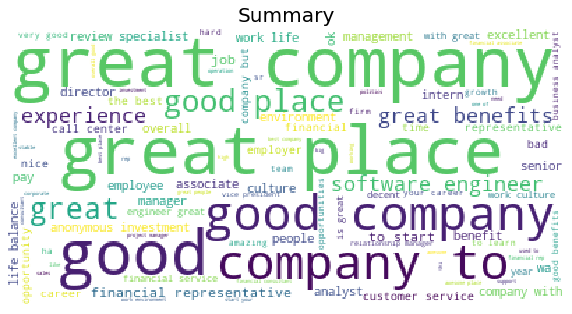

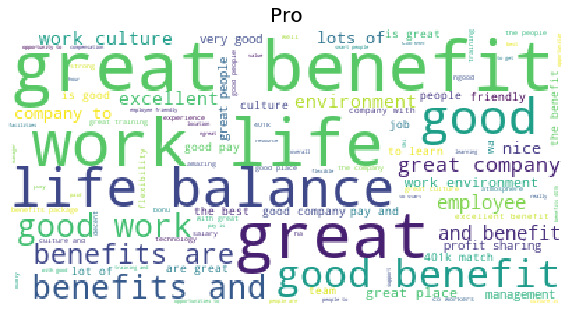

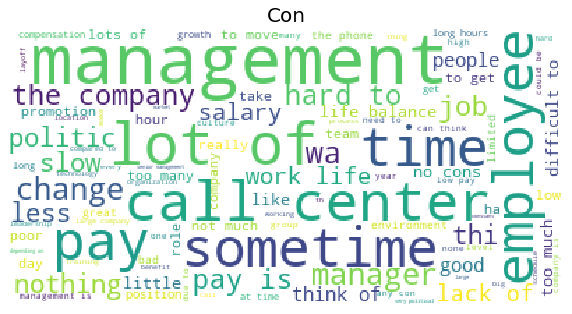

In [9]:
# plot 'Summary','Pro'and 'Cro' in wordcloud

for column_name in ['Summary', 'Pro', 'Con']:
    plot_wordcloud(column_name)

**Findings**: 
* The most common words in `Summary` are positive, which is consistent with our previous plot where 60% of employees recommend this company.
* Employees love this company because of its great benefits and good work-life balance.
* It appears employees' complaints are mostly about management and the job nature of call centers.

#### Visualize The Most Common Bi-grams Words

In the previous wordclouds, we visualized top uni-gram words, now we will visualize top bi-gram words and try to capture the topics. To do this, we will need to create corpus for each text column.

In [10]:
# pre-processing the words

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def lemmatize_word(text):
    
    lem = WordNetLemmatizer()     
    stop_words = set(stopwords.words("english"))
    tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    no_stops = [t for t in tokens if t not in stop_words]   
    
    return " ".join([lem.lemmatize(word) for word in no_stops]) # make text in each row into one string
    

In [11]:
# transform the dataframe on the 3 text columns, each column is a corpus

df_cleaned["Summary_corpus"] = df_cleaned["Summary"].apply(lemmatize_word)
df_cleaned["Pro_corpus"] = df_cleaned["Pro"].apply(lemmatize_word)
df_cleaned["Con_corpus"] = df_cleaned["Con"].apply(lemmatize_word)

In [12]:
# let's take a look at the first 5 rows of the 3 text columns

df_cleaned[['Summary_corpus','Pro_corpus','Con_corpus']].head()

,Summary_corpus,Pro_corpus,Con_corpus
0,political,privately owned company look long term,risk averse management know grow business
1,great caveat emptor,industry leader many way one best business ano...,lot uncertainty top employee feel loop empower...
2,great place work,privately held right thing customer though cha...,somewhat political promotion process probably ...
3,anonymous good good,fast paced sale environment spunk,squeezing productivity
4,would want work,fun fun fun fun fun,sometimes get little boring


In [13]:
# define a function to get the top bigram words

def get_top_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(corpus)
    dtm = vec.transform(corpus)
    sum_words = dtm.sum(axis=0)
    # sum_words only has 1 row, so we pass [0,idx] to sum_words
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)   
    
    return words_freq[:n]

In [14]:
# define a function to plot the top bigram words

def plot_top_bigram(data, title):
    import seaborn as sns
    sns.set(rc={'figure.figsize':(10,8)})
    h=sns.barplot(x="Bi-gram", y="Frequency", data=data)
    h.set_xticklabels(h.get_xticklabels(), rotation=90)
    plt.title(title, fontsize=20)
    plt.show()

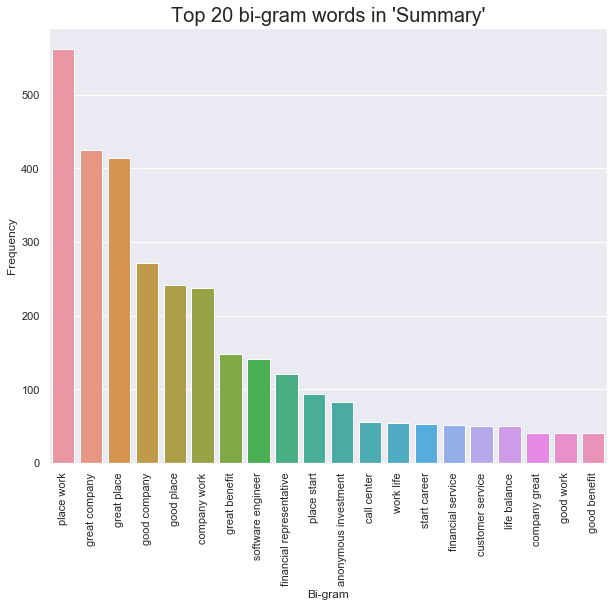

In [15]:
# plot top 20 bi-gram in 'Summary'

top_2words_sum = get_top_bigram(df_cleaned['Summary_corpus'], n=20)
top_2words_sum_df = pd.DataFrame(top_2words_sum,columns=["Bi-gram", "Frequency"])

plot_top_bigram(top_2words_sum_df, "Top 20 bi-gram words in 'Summary'")

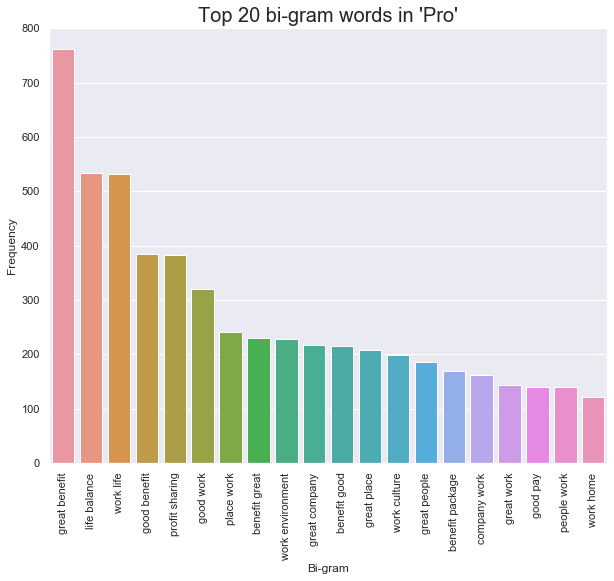

In [16]:
# plot top 20 bi-gram in 'Pro'

top_2words_pro = get_top_bigram(df_cleaned.Pro_corpus, n=20)
top_2words_pro_df = pd.DataFrame(top_2words_pro,columns=["Bi-gram", "Frequency"])

plot_top_bigram(top_2words_pro_df,"Top 20 bi-gram words in 'Pro'")

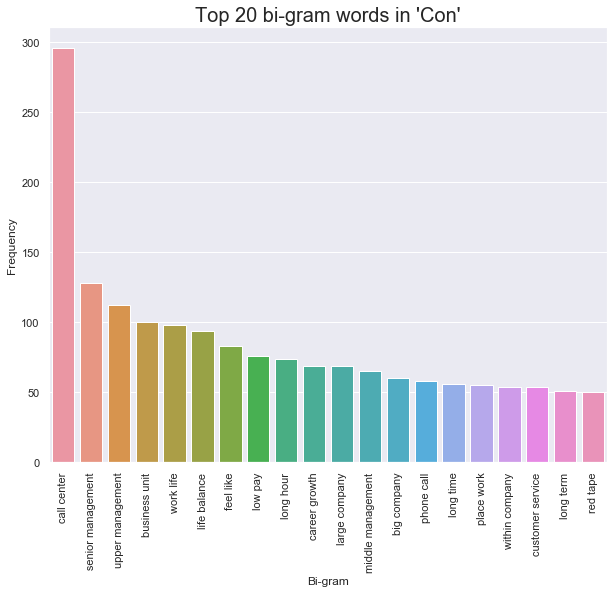

In [17]:
# plot top 20 bi-gram in 'Con'

top_2words_con = get_top_bigram(df_cleaned.Con_corpus, n=20)
top_2words_pro_df = pd.DataFrame(top_2words_con,columns=["Bi-gram", "Frequency"])

plot_top_bigram(top_2words_pro_df,"Top 20 bi-gram words in 'Con'")

**Findings:**

* Bi-gram bar plots give us great insights on the topic discussed. It is clear people love this company mainly because of the company's generous benefits.
* The negative comments mostly come from employees in the call center. They seem to be complaining about answering phone calls for long hours and with low pay. Other issues include: people do not like the red tape culture in a large company, they don't approve senior management, some employees don't think there are great career advancement opportunities.
* Recall from previous sentiment analysis, we noticed employees with the job title 'Financial Representative' tend to give negative comments, if Financial Representatives are working in the call center, then this is a clear message that this company needs to make some improvements in their call centers.
* This bi-gram chart is a great starting point in top-modeling. We will explore more with Latent Dirichlet Allocation (LDA) technique and verify the modeling results with these plots.

## 2. Topic Modeling

The ultimate goal of topic modeling is to find various topics that are present in the corpus. Each document in the corpus will be made up of one or more topics.To use a topic modeling technique, we need to provide:
- A corpus 
- The number of topics

There are 2 ways to define the number of topics. One is from the previous key-words visualizations, another way is to use K-means clustering. I tried K-Means clustering, but this algorithm is sensitive to initialization, each rerun gives me very different results, therefore I decide to define the number of topics from the visualizations using my best judgement: 3 topics in `Summary`, 5 topics in `Pro` and `Con`.

Usually, LDA uses the bag-of-words feature representation to represent a document, meaning order does not matter. However, in this section, we will apply 2 feature extraction techniques to perform LDA:
- Bag-of-words
- TF-IDF 

#### Create Corpus

In bi-gram words visualization, we have created corpus for each text column, but that corpus is one big string. We need to transform previous corpus such that each row is in a list.

In [18]:
# split corpus column so each row is in a list

summary_corpus_list = df_cleaned["Summary_corpus"].str.split()
pro_corpus_list = df_cleaned["Pro_corpus"].str.split()
con_corpus_list = df_cleaned["Con_corpus"].str.split()

In [19]:
# take a look at what the corpus with list looks like, use 'Summary' as example

summary_corpus_list.head()

0                [political]
1    [great, caveat, emptor]
2       [great, place, work]
3    [anonymous, good, good]
4        [would, want, work]
Name: Summary_corpus, dtype: object

#### Convert Corpus to Vectors

Now let's convert these corpora `summary_corpus_list`,`pro_corpus_list`,`con_corpus_list` into vectors, using Bag-of-Words and TF-IDF.

#### 1.Bag-of-Words

In [20]:
# create a dictionary which is a mapping between words and their integer ids

dictionary_sum = gensim.corpora.Dictionary(summary_corpus_list)
dictionary_pro = gensim.corpora.Dictionary(pro_corpus_list)
dictionary_con = gensim.corpora.Dictionary(con_corpus_list)

Take a look at the first 11 words in the dictionary. Note the dictionary consists of the word ID and the word pairs. The word ID is created for this specific corpus.

In [21]:
# print out the first 11 words in the 'Summary' dictionary so we know how it works behind the scenes

for i, (k, v) in enumerate(dictionary_sum.iteritems()):
    print(k, v)
    if i > 10:
        break

0 political
1 caveat
2 emptor
3 great
4 place
5 work
6 anonymous
7 good
8 want
9 would
10 begin
11 burned


`doc2bow` converts document into the Bag-of-Words (BoW) format, which is a list of (token_id, token_count) tuples.

In [22]:
# convert corpus to vectors using Bag-of-words

bow_corpus_summary = [dictionary_sum.doc2bow(doc) for doc in summary_corpus_list]
bow_corpus_pro = [dictionary_pro.doc2bow(doc) for doc in pro_corpus_list]
bow_corpus_con = [dictionary_con.doc2bow(doc) for doc in con_corpus_list]

In [23]:
# take a look at the vectors (word_id and count), use 'Con' as example

bow_corpus_con[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

#### 2. TF-IDF

Here, we simply use TF-IDF model to transform previous Bag-of-words vectors into TF-IDF vectors, then the word count will become a weight.

In [24]:
# fit and transform bow vectors into tf-idf vectors

from gensim import corpora, models

tfidf_summary = models.TfidfModel(bow_corpus_summary)[bow_corpus_summary] 
tfidf_pro = models.TfidfModel(bow_corpus_pro)[bow_corpus_pro]
tfidf_con = models.TfidfModel(bow_corpus_con)[bow_corpus_con]

In [25]:
# take a look at the same vector to confirm word counts are changed into weights

tfidf_con[0]

[(0, 0.6074378216999448),
 (1, 0.30830941005669077),
 (2, 0.4288122562381671),
 (3, 0.3163306696791809),
 (4, 0.17817704144239752),
 (5, 0.46933197063699905)]

In [26]:
# define a function to run LDA model

import joblib
from gensim import models

def run_lda(corpus, dictionary, n_topics, n_passes,file_name):
    ''' This function returns topic distribution. '''
    lda = models.LdaMulticore(corpus=corpus, num_topics=n_topics, id2word=dictionary, passes=n_passes, random_state=42)
    
    # save model results
    joblib.dump(lda.print_topics(),f"{file_name}_topics")  
    joblib.dump(lda,f"{file_name}_lda")    

### Topic Modeling with LDA

#### 1. Bag of Words

**Note**:
Since it takes a long time to run each model, I have saved the model results with joblib and only load the results when I restart the kernel. Therefore the initial codes of `run_lda` have been commented out. 

In [27]:
# run_lda(bow_corpus_summary,dictionary_sum, n_topics=3, n_passes=50,file_name='summary_bow')

In [28]:
summary_bow_topics = joblib.load('summary_bow_topics')
summary_bow_topics

[(0,
  '0.133*"great" + 0.116*"work" + 0.098*"company" + 0.093*"good" + 0.087*"place" + 0.028*"benefit" + 0.015*"career" + 0.015*"best" + 0.014*"culture" + 0.013*"balance"'),
 (1,
  '0.063*"anonymous" + 0.055*"financial" + 0.031*"representative" + 0.026*"service" + 0.025*"investment" + 0.023*"review" + 0.021*"associate" + 0.019*"job" + 0.014*"ok" + 0.011*"year"'),
 (2,
  '0.032*"engineer" + 0.030*"software" + 0.029*"manager" + 0.023*"environment" + 0.019*"senior" + 0.017*"analyst" + 0.015*"amazing" + 0.015*"consultant" + 0.013*"call" + 0.012*"center"')]

In [29]:
# run_lda(bow_corpus_pro,dictionary_pro, n_topics=5, n_passes=50,file_name='pro_bow')

In [30]:
pro_bow_topics = joblib.load('pro_bow_topics')
pro_bow_topics

[(0,
  '0.120*"good" + 0.112*"work" + 0.067*"great" + 0.055*"balance" + 0.049*"benefit" + 0.045*"life" + 0.026*"company" + 0.023*"culture" + 0.019*"pay" + 0.019*"people"'),
 (1,
  '0.034*"great" + 0.031*"good" + 0.023*"opportunity" + 0.017*"training" + 0.015*"get" + 0.015*"lot" + 0.012*"benefit" + 0.011*"role" + 0.010*"job" + 0.010*"bonus"'),
 (2,
  '0.038*"company" + 0.022*"anonymous" + 0.021*"benefit" + 0.021*"employee" + 0.017*"people" + 0.017*"best" + 0.016*"great" + 0.014*"work" + 0.010*"industry" + 0.009*"care"'),
 (3,
  '0.041*"work" + 0.034*"friendly" + 0.028*"environment" + 0.026*"people" + 0.023*"culture" + 0.022*"benefit" + 0.020*"great" + 0.017*"free" + 0.016*"employee" + 0.012*"smart"'),
 (4,
  '0.078*"benefit" + 0.053*"great" + 0.028*"profit" + 0.027*"sharing" + 0.024*"match" + 0.018*"pay" + 0.013*"health" + 0.012*"opportunity" + 0.011*"lot" + 0.011*"package"')]

In [31]:
# run_lda(bow_corpus_con,dictionary_con, n_topics=5, n_passes=50,file_name='con_bow')

In [32]:
con_bow_topics = joblib.load('con_bow_topics')
con_bow_topics

[(0,
  '0.034*"management" + 0.016*"change" + 0.015*"company" + 0.015*"lot" + 0.014*"many" + 0.011*"politics" + 0.010*"get" + 0.010*"opportunity" + 0.010*"work" + 0.010*"much"'),
 (1,
  '0.024*"company" + 0.011*"employee" + 0.011*"year" + 0.010*"time" + 0.009*"job" + 0.008*"work" + 0.007*"like" + 0.007*"new" + 0.006*"opportunity" + 0.006*"lot"'),
 (2,
  '0.024*"call" + 0.021*"pay" + 0.016*"phone" + 0.016*"job" + 0.015*"get" + 0.012*"work" + 0.012*"day" + 0.012*"center" + 0.012*"time" + 0.010*"customer"'),
 (3,
  '0.040*"work" + 0.031*"con" + 0.025*"slow" + 0.023*"nothing" + 0.022*"growth" + 0.019*"le" + 0.017*"think" + 0.016*"none" + 0.015*"technology" + 0.014*"much"'),
 (4,
  '0.018*"management" + 0.018*"manager" + 0.015*"people" + 0.014*"employee" + 0.012*"work" + 0.011*"anonymous" + 0.011*"company" + 0.008*"get" + 0.007*"team" + 0.007*"job"')]

#### 2.TF-IDF

In [33]:
# run_lda(tfidf_summary,dictionary_sum, n_topics=3,n_passes=50,file_name='summary_tfidf')

In [34]:
summary_tfidf_topics = joblib.load('summary_tfidf_topics')
summary_tfidf_topics

[(0,
  '0.091*"great" + 0.080*"company" + 0.076*"good" + 0.075*"work" + 0.068*"place" + 0.026*"benefit" + 0.015*"experience" + 0.015*"career" + 0.014*"best" + 0.014*"start"'),
 (1,
  '0.052*"financial" + 0.038*"representative" + 0.026*"review" + 0.024*"culture" + 0.018*"job" + 0.016*"analyst" + 0.016*"rep" + 0.015*"intern" + 0.014*"service" + 0.013*"ok"'),
 (2,
  '0.031*"anonymous" + 0.028*"engineer" + 0.025*"software" + 0.025*"manager" + 0.019*"associate" + 0.017*"senior" + 0.017*"consultant" + 0.014*"investment" + 0.014*"environment" + 0.014*"overall"')]

In [35]:
# run_lda(tfidf_pro,dictionary_pro, n_topics=5,n_passes=50,file_name='pro_tfidf')

In [36]:
pro_tfidf_topics = joblib.load('pro_tfidf_topics')
pro_tfidf_topics

[(0,
  '0.043*"work" + 0.041*"good" + 0.036*"balance" + 0.034*"life" + 0.032*"great" + 0.023*"benefit" + 0.020*"culture" + 0.020*"company" + 0.018*"people" + 0.017*"environment"'),
 (1,
  '0.008*"great" + 0.007*"company" + 0.007*"move" + 0.006*"people" + 0.006*"opportunity" + 0.006*"benefit" + 0.006*"good" + 0.006*"lot" + 0.006*"employee" + 0.005*"job"'),
 (2,
  '0.011*"company" + 0.009*"great" + 0.008*"benefit" + 0.008*"opportunity" + 0.008*"anonymous" + 0.008*"employee" + 0.007*"good" + 0.007*"lot" + 0.007*"package" + 0.006*"care"'),
 (3,
  '0.011*"work" + 0.011*"environment" + 0.011*"culture" + 0.009*"great" + 0.009*"good" + 0.009*"team" + 0.009*"people" + 0.007*"challenging" + 0.007*"supportive" + 0.007*"positive"'),
 (4,
  '0.023*"profit" + 0.023*"sharing" + 0.021*"match" + 0.015*"benefit" + 0.013*"great" + 0.012*"health" + 0.011*"bonus" + 0.010*"good" + 0.010*"insurance" + 0.009*"training"')]

In [37]:
# run_lda(tfidf_con,dictionary_con, n_topics=5,n_passes=50,file_name='con_tfidf')

In [38]:
con_tfidf_topics = joblib.load('con_tfidf_topics')
con_tfidf_topics

[(0,
  '0.008*"management" + 0.005*"many" + 0.005*"company" + 0.005*"work" + 0.004*"change" + 0.004*"lack" + 0.004*"opportunity" + 0.004*"much" + 0.004*"growth" + 0.004*"manager"'),
 (1,
  '0.007*"work" + 0.007*"call" + 0.006*"job" + 0.006*"time" + 0.006*"phone" + 0.005*"long" + 0.005*"company" + 0.005*"get" + 0.005*"center" + 0.005*"hour"'),
 (2,
  '0.022*"con" + 0.012*"none" + 0.012*"think" + 0.010*"pay" + 0.010*"salary" + 0.008*"low" + 0.007*"growth" + 0.007*"much" + 0.007*"company" + 0.007*"slow"'),
 (3,
  '0.019*"nothing" + 0.005*"mention" + 0.005*"yet" + 0.004*"everything" + 0.004*"think" + 0.003*"slow" + 0.003*"good" + 0.002*"intense" + 0.002*"adoption" + 0.002*"specific"'),
 (4,
  '0.007*"management" + 0.005*"political" + 0.004*"employee" + 0.004*"culture" + 0.004*"micro" + 0.003*"career" + 0.003*"company" + 0.003*"manager" + 0.003*"top" + 0.003*"heavy"')]

#### Analyze Model Results

Let's use our best judgement to extract the topics. It is obviously hard to identify topics based on the modeling output because these are all unigram words. We will need to refer back to previous keywords plots.

The topics in `Summary` are:
- Great place
- Benefits
- Call center

The topics in `Pro` are:
- Work-life balance
- Good pay
- Career opportunity
- Good people
- Good benefits (profit-sharing,bonus,401k match)

The topics in `Con` are:
- Management
- Call center/Phone call
- Low pay
- Slow
- Culture and politics

#### Model Evaluation

We will calculate model's coherence score to evaluate its performance,take column `Con` as an example.

In [39]:
# load our previously trained models

con_bow_lda = joblib.load('con_bow_lda')
con_tfidf_lda = joblib.load('con_tfidf_lda')

In [40]:
con_for_test = [ x.split() for x in df_cleaned["Con_corpus"].to_list()]

In [41]:
from gensim.models import CoherenceModel

coherence_model_bow_lda = CoherenceModel(model=con_bow_lda, texts=con_for_test, dictionary=dictionary_con, coherence='c_v')
coherence_bow_lda = coherence_model_bow_lda.get_coherence()

print('\nCoherence Score: ', coherence_bow_lda) 


Coherence Score:  0.4533002481255597


In [42]:
coherence_model_tfidf_lda = CoherenceModel(model=con_tfidf_lda, texts=con_for_test, dictionary=dictionary_con, coherence='c_v')
coherence_tfidf_lda = coherence_model_tfidf_lda.get_coherence()

print('\nCoherence Score: ', coherence_tfidf_lda)


Coherence Score:  0.40791186906612015


Based on coherence score,Bag-of-Words model did better than TF-IDF.Let's test one sample from column `Con` by visually check the text and the topics derived.

In [43]:
# randomly choose one comment from 'Con'

df_cleaned.loc[561,'Con']

'It was a lot of hard work and they expect a lot out of you, but this is a good thing!'

In [44]:
# test bag-of-words model

for index, score in sorted(con_bow_lda[bow_corpus_con[561]], key=lambda x: x[1], reverse=True): 
    print(f"{index}, {score}, {con_bow_lda.print_topic(index, 5)}") # only print the first 5 words

0, 0.5408996939659119, 0.034*"management" + 0.016*"change" + 0.015*"company" + 0.015*"lot" + 0.014*"many"
4, 0.3820987343788147, 0.018*"management" + 0.018*"manager" + 0.015*"people" + 0.014*"employee" + 0.012*"work"
3, 0.02599671669304371, 0.040*"work" + 0.031*"con" + 0.025*"slow" + 0.023*"nothing" + 0.022*"growth"
2, 0.02560080960392952, 0.024*"call" + 0.021*"pay" + 0.016*"phone" + 0.016*"job" + 0.015*"get"
1, 0.02540399506688118, 0.024*"company" + 0.011*"employee" + 0.011*"year" + 0.010*"time" + 0.009*"job"


In [45]:
# test tf-idf model

for index, score in sorted(con_tfidf_lda[tfidf_con[561]], key=lambda x: x[1], reverse=True): 
    print(f"{index}, {score}, {con_tfidf_lda.print_topic(index, 5)}")

1, 0.755190372467041, 0.007*"work" + 0.007*"call" + 0.006*"job" + 0.006*"time" + 0.006*"phone"
2, 0.06186027452349663, 0.022*"con" + 0.012*"none" + 0.012*"think" + 0.010*"pay" + 0.010*"salary"
0, 0.06170818209648132, 0.008*"management" + 0.005*"many" + 0.005*"company" + 0.005*"work" + 0.004*"change"
4, 0.060880839824676514, 0.007*"management" + 0.005*"political" + 0.004*"employee" + 0.004*"culture" + 0.004*"micro"
3, 0.06036030873656273, 0.019*"nothing" + 0.005*"mention" + 0.005*"yet" + 0.004*"everything" + 0.004*"think"


**Comment:**
The Bag-of-Words model suggests this is topic # 0 and topic # 4, which are about management and work. TF-IDF model suggests this is about topic # 1, which is about call center. Based on the original sentence 'It was a lot of hard work and they expect a lot out of you, but this is a good thing', Bag-of-Words model made a correct prediction.

#### Test Model on Unseen Data

In [46]:
# create a new text 

unseen_text = 'the pay is good but the hours on phone call can be very long'
transformed_text = lemmatize_word(unseen_text)

In [47]:
# convert transformed_text to vector using bag-of-words and tf-idf 

bow_text = dictionary_con.doc2bow(transformed_text.split())
tfidf_text = models.TfidfModel(bow_corpus_con)[bow_text]

In [48]:
# test bag-of-words model

for index, score in sorted(con_bow_lda[bow_text], key=lambda x: x[1], reverse=True): 
    print(f"{index}, {score}, {con_bow_lda.print_topic(index, 5)}")

2, 0.8838239312171936, 0.024*"call" + 0.021*"pay" + 0.016*"phone" + 0.016*"job" + 0.015*"get"
3, 0.029485125094652176, 0.040*"work" + 0.031*"con" + 0.025*"slow" + 0.023*"nothing" + 0.022*"growth"
1, 0.028969231992959976, 0.024*"company" + 0.011*"employee" + 0.011*"year" + 0.010*"time" + 0.009*"job"
4, 0.028943214565515518, 0.018*"management" + 0.018*"manager" + 0.015*"people" + 0.014*"employee" + 0.012*"work"
0, 0.028778525069355965, 0.034*"management" + 0.016*"change" + 0.015*"company" + 0.015*"lot" + 0.014*"many"


In [49]:
# test tf-idf model

for index, score in sorted(con_tfidf_lda[tfidf_text], key=lambda x: x[1], reverse=True): 
    print(f"{index}, {score}, {con_tfidf_lda.print_topic(index, 5)}")

1, 0.7647968530654907, 0.007*"work" + 0.007*"call" + 0.006*"job" + 0.006*"time" + 0.006*"phone"
2, 0.05934898555278778, 0.022*"con" + 0.012*"none" + 0.012*"think" + 0.010*"pay" + 0.010*"salary"
0, 0.058912187814712524, 0.008*"management" + 0.005*"many" + 0.005*"company" + 0.005*"work" + 0.004*"change"
3, 0.05850892886519432, 0.019*"nothing" + 0.005*"mention" + 0.005*"yet" + 0.004*"everything" + 0.004*"think"
4, 0.058433033525943756, 0.007*"management" + 0.005*"political" + 0.004*"employee" + 0.004*"culture" + 0.004*"micro"


**Comment:**
The Bag-of-words model suggests this is topic # 2 and TF-IDF model suggests this is topic # 0. These 2 topics are both about call center. Our models did great on this test.

## 3. Analyze Unhappy Groups with Spacy

In the previous sentiment analysis, we noticed that employees with the job title 'Financial Representative',' Anonymous Employee' or 'Project Manager' submitted the most negative comments. Let's dive into these groups and see if we can find out more about the root causes.

In [50]:
# subset the comments from the most unhappy 3 job families

unhappy_fin_rep = df_cleaned.loc[df_cleaned['Job Title']=='Financial Representative',['Summary','Pro','Con']]
unhappy_pro_mgr = df_cleaned.loc[df_cleaned['Job Title']=='Project Manager',['Summary','Pro','Con']]
unhappy_ano_eme = df_cleaned.loc[df_cleaned['Job Title']=='Anonymous Employee',['Summary','Pro','Con']]

In [51]:
len(unhappy_fin_rep),len(unhappy_pro_mgr),len(unhappy_ano_eme)

(318, 93, 1578)

In [52]:
# define a function to do rule-based matching

import spacy
from spacy.matcher import Matcher


def find_adj_noun(text):
    """
    This function will pull out words that follow the pattern adjective + noun + noun(optional)
    """
    text = text.lower()
    nlp = spacy.load('en_core_web_sm')
    matcher = Matcher(nlp.vocab)
    
    # set a pattern to look for adjective + noun + noun (optional)
    pattern = [{'POS': 'ADJ'}, {'POS': 'NOUN'},{'POS': 'NOUN', 'OP': '?'}]
    matcher.add('pattern_name', None, pattern)
    doc = nlp(text)
    matches = matcher(doc)
    
    matched_list = []
    for match_id, start, end in matches:
        matched_span = doc[start:end]
        matched_list.append(matched_span.text)
        
    return matched_list

In [53]:
# top unhappy reasons for Financial Representatives

con_matched_finrep = find_adj_noun(text = unhappy_fin_rep ['Con'].to_string())
Counter(con_matched_finrep).most_common(20)

[('upper management', 3),
 ('low pay', 3),
 ('long hours', 3),
 ('low end', 2),
 ('much room', 2),
 ('average pay', 2),
 ('upward mobility', 2),
 ('low compensation', 2),
 ('upward movement', 2),
 ('bad management', 2),
 ('exact shift', 1),
 ('better recognition', 1),
 ('many employees', 1),
 ('poor salary', 1),
 ('juvenile managemen', 1),
 ('loyal e', 1),
 ('anonymous career', 1),
 ('anonymous career track', 1),
 ('down size', 1),
 ('direct managers', 1)]

**Findings:**

Financial Representatives are complaining about:
- Low pay
- Long hours
- Management(upper management, bad management, juvenile management, direct managers)

We assume the low pay and long hours issue is from call center.

In [54]:
# top unhappy reasons for Project Managers

con_matched_promgr = find_adj_noun(text = unhappy_pro_mgr['Con'].to_string())
Counter(con_matched_promgr).most_common(20)

[('executive management', 2),
 ('top management', 2),
 ('constant distraction', 1),
 ('executive management changes', 1),
 ('entire organization', 1),
 ('tiny raise', 1),
 ('great place', 1),
 ('annual performance', 1),
 ('annual performance reviews', 1),
 ('constant org', 1),
 ('recent years', 1),
 ('autocratic management', 1),
 ('autocratic management style', 1),
 ('senior mana', 1),
 ('good pay', 1),
 ('good pay packet', 1),
 ('many processes', 1),
 ('late hours', 1),
 ('frequent reorgs', 1),
 ('savvy folks', 1)]

**Findings:**

Project Managers are complaining about:
- Management. We see a heavy focus on this from the Project Managers group.
- Annual performance review.They could be unhappy with the review process.

In [55]:
# top unhappy reasons for Anonymous Employees

con_matched_anoeme = find_adj_noun(text = unhappy_ano_eme['Con'].to_string())
Counter(con_matched_anoeme).most_common(20)

[('long hours', 17),
 ('upper management', 14),
 ('big company', 12),
 ('low pay', 10),
 ('large company', 10),
 ('hard work', 9),
 ('red tape', 8),
 ('good place', 7),
 ('upward mobility', 7),
 ('limited career', 6),
 ('senior management', 5),
 ('good company', 4),
 ('low salary', 4),
 ('average pay', 4),
 ('many people', 4),
 ('middle management', 4),
 ('low salaries', 4),
 ('old school', 4),
 ('great place', 4),
 ('poor leadership', 3)]

**Findings:**

Anonymous employees could come from any job family, so it can be a combination from the above two groups or include other groups:
- Low pay
- Long hours
- Upper management/autocratic management
- Red tape of a large company
- Constant changes/frequent reorganization

## 4. Conclusions

At the beginning of this project, we have defined the problem statement and now we have answers to all of the questions.

- **What employees like and dislike about this company?**

Employees love the good pay, generous benefits, profit sharing and a good work-life balance. Employees from call centers complain about the low pay, long hours handling phone calls and the management team. Project managers complain about the upper management team. Other anonymous employees which could consist of any job family complain about the aforementioned issues plus red tape of large corporation and constant changes.</font> 


- **Has the company’s reputation gotten better or worse in the recent year?** 

This company did great compared to other companies’ average ratings on Glassdoor. The majority of employees are satisfied with the company. Its rating has been increasing since 2008 with small dips in 2011, 2013 and 2017.</font> 

- **Which job families have the highest and lowest satisfaction rates?** 

Among the most frequent job titles, Financial Associate group has the lowest satisfaction and Relationship Managers give the highest ratings. Since we know the negative comments are from call center employees, our best guess is Financial Representatives work in the call center.</font> 

- **What are the keywords that people say about this company?**

The keywords are most clear in the top bi-gram plots. They are: good salary, good benefits, generous profit sharing, big company, work-life balance, upper management, low pay, long hours.</font> 

- **What can this company do to improve employee engagement?**

This analysis identified the negative comments are mainly from call center employees. We suggest the company look into the salary, working hours and find solutions to address these issues. If call center employee engagement increases, the total employee engagement will increase significantly. </font> 

**Finally, we find LDA topic modeling works better with Bag-of-Words than TF-IDF for this dataset.**

## 5. Project Contribution

This project has created a standard workflow for similar tasks. Given any company’s Glassdoor review data, the same structure and code can be applied with little tweaks, especially the data cleaning code blocks can be used without change since all Glassdoor review data follow the same format.

## 6. Limitation and Future Work

**Limitations:**
Since there are 1578 unhappy employees submitted anonymously, we couldn't do a more granular analysis on specific job families. It is our assumption that Financial Representatives work in call centers, if this is untrue, we would need to analyze this further.

**Future Work:** 
We could do a similar analysis on this company's competitor and see how they compare and what they can learn from each other. 

## 7. Acknowledgement

I would like to extend my sincere thanks to Glassdoor for allowing me web-scrapping its data, so I could work on this project. 